In [101]:
from siml.sk_utils import *
from siml.signal_analysis_utils import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import defaultdict, Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.metrics import classification_report
from detecta import detect_peaks
from scipy.fftpack import fft
from scipy.signal import welch
from sklearn.model_selection import train_test_split  

## 加载数据文件

In [102]:
typeDescription = {
    0: 'normal',
    1: 'pothole',
    2: 'transverse',
}


def readFile(filename):
    return np.loadtxt(filename)

In [103]:
folderPath = '../../data/Final_Version/poor/datasets/'
dataFile = ['dataX.txt', 'dataY.txt', 'dataZ.txt']
labelFile = ['dataLabel.txt']

signals = []
for file in dataFile:
    dataPath = folderPath+file
    signals.append(np.loadtxt(dataPath))
signals = np.transpose(np.array(signals), (1, 2, 0))
print('数据集：', signals.shape)

labelFilePath = folderPath+labelFile[0]
dataLabel = np.loadtxt(labelFilePath)
anomalyType = list(dataLabel[:, 0])

dic = {}
temp = Counter(anomalyType)
for key in temp.keys():
    dic[typeDescription[key]] = temp[key]
print(dic)

数据集： (899, 64, 3)
{'normal': 817, 'pothole': 69, 'transverse': 13}


## 数据可视化

In [104]:
N = 64 #样本数
f_s = 50 #采样频率
denominator = 10

In [105]:
#选择一个信号样本（signal为长度128的列表*3）
signal_no = 10
signal = signals[signal_no, :, :]
label = anomalyType[signal_no]
roadType = typeDescription[label]


In [106]:
#时域
def get_values(y_values, N, f_s):
    f_values = np.linspace(0.0, N/f_s, N)
    return f_values, y_values

#FFT
def get_fft_values(y_values, N, f_s):
    f_values = np.linspace(0.0, f_s/2.0, N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

#PSD
def get_psd_values(y_values, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

#Autocorrelation
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]
 
def get_autocorr_values(y_values, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([ 1.0*jj/f_s for jj in range(0, N)])
    return x_values, autocorr_values


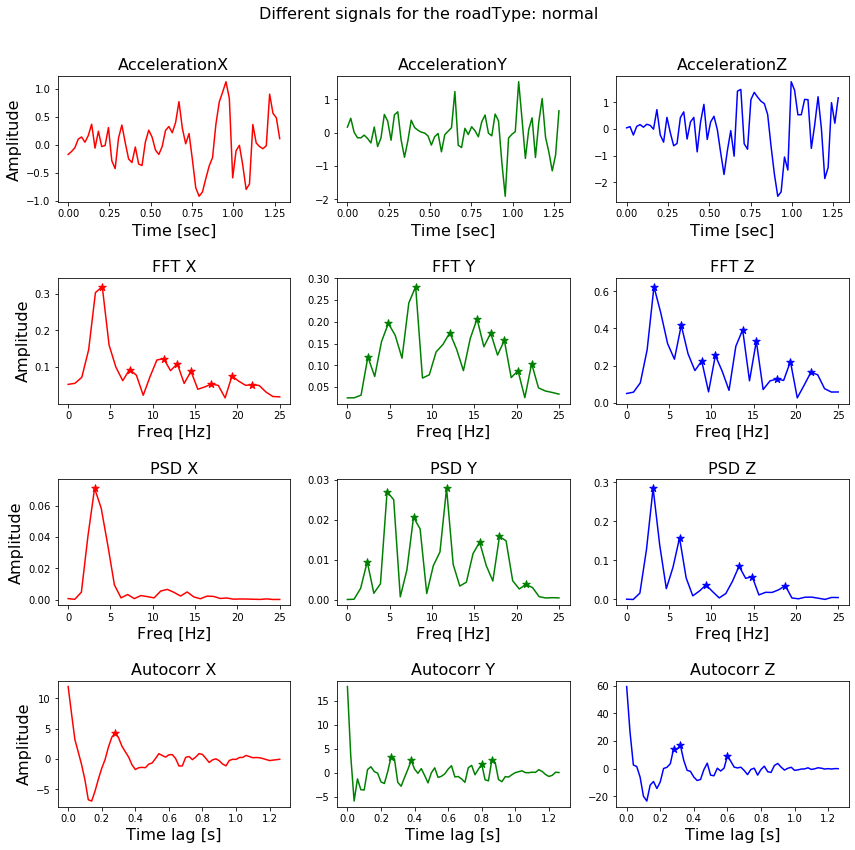

In [107]:
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the roadType: {}"
 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['AccelerationX', 'AccelerationY', 'AccelerationZ'],
            ['FFT X', 'FFT Y', 'FFT Z'],
            ['PSD X', 'PSD Y', 'PSD Z'],
            ['Autocorr X', 'Autocorr Y', 'Autocorr Z']
           ]
 
list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
f.suptitle(suptitle.format(roadType), fontsize=16)
 
for row_no in range(0,4):
    for comp_no in range(0,3):
        col_no = comp_no 
        plot_no = comp_no 
        color = colors[plot_no]
        label = labels[plot_no]
 
        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]
 
        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)
 
        signal_component = signal[:, comp_no]
        x_values, y_values = value_retriever(signal_component, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
        '''
            if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))  
        '''
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

## 特征提取

In [108]:
def get_first_n_peaks(x, y, no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        ans = np.argsort(y)[-5:]
        ans = ans[np.argsort(ans)]
        return list(x[ans]), list(y[ans])
        # return x_[:no_peaks], y_[:no_peaks]
    else:  # 少于5个peaks，以0填充
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks

'''
def get_first_n_peaks(x, y, no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        ans = np.argsort(y)[-5:]
        ans = ans[np.argsort(ans)]
        return list(x[ans]), list(y[ans])
        # return x_[:no_peaks], y_[:no_peaks]
    else:  # 少于5个peaks，以0填充
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
'''


def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(
        x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y


def extract_features(dataset, N, f_s, denominator):
    percentile = 5
    list_of_features = []

    for signal_no in range(0, len(dataset)):
        features = []  # 5*2*3*3

        for signal_comp in range(0, dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]

            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            # set minimum peak height
            #mph = signal_min + (signal_max - signal_min)/denominator
            mph = signal_min

            features += get_features(*get_psd_values(signal, N, f_s), mph)
            features += get_features(*get_fft_values(signal, N, f_s), mph)
            features += get_features(*
                                     get_autocorr_values(signal, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features)

In [109]:
features = extract_features(
    signals, N, f_s, denominator)

In [110]:
print(features.shape)
labels = np.array(anomalyType)

(899, 90)


In [111]:
StandardScaler().fit_transform(features)
Normalizer().fit_transform(features)

array([[0.03784578, 0.0630763 , 0.10092208, ..., 0.16663706, 0.10141598,
        0.12387157],
       [0.04615021, 0.12691307, 0.18460083, ..., 0.0957834 , 0.09549503,
        0.07827633],
       [0.04938958, 0.08643177, 0.12347395, ..., 0.09814612, 0.04288003,
        0.03442326],
       ...,
       [0.03153518, 0.05255864, 0.10511727, ..., 0.08649289, 0.10203802,
        0.0770544 ],
       [0.0476821 , 0.08344368, 0.11920526, ..., 0.19962135, 0.11815124,
        0.08639772],
       [0.03416456, 0.05694093, 0.09110548, ..., 0.11426868, 0.12202632,
        0.08432922]])

## 信号分类

In [112]:
def randomize(features, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_features = features[permutation, :]
    shuffled_labels = labels[permutation]
    return shuffled_features, shuffled_labels

iteration = 100
warnings.filterwarnings('ignore')

### Logistic Regression

In [113]:
yTest, yPredict = [], []
trainingScore, testingScore = 0, 0
for i in range(iteration):
    X, Y = randomize(features,labels)
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, Y_train)
    Y_test_pred = clf.predict(X_test)
    yTest.extend(Y_test)
    yPredict.extend(Y_test_pred)
    trainingScore += clf.score(X_train, Y_train)
    testingScore += clf.score(X_test, Y_test)
print("Results of Logistic Regression")
print("Accuracy on training set is : {}".format(trainingScore/iteration))
print("Accuracy on test set is : {}".format(testingScore/iteration))
print(classification_report(yTest, yPredict,digits=3))

Results of Logistic Regression
Accuracy on training set is : 0.9620508744038158
Accuracy on test set is : 0.9088888888888892
              precision    recall  f1-score   support

         0.0      0.950     0.961     0.956     24542
         1.0      0.523     0.428     0.471      2071
         2.0      0.124     0.150     0.136       387

    accuracy                          0.909     27000
   macro avg      0.532     0.513     0.521     27000
weighted avg      0.905     0.909     0.907     27000



### Support Vector Machine

In [114]:
yTest, yPredict = [], []
trainingScore, testingScore = 0, 0
for i in range(iteration):
    X, Y = randomize(features,labels)
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
    clf = svm.SVC()
    clf.fit(X_train, Y_train)
    Y_test_pred = clf.predict(X_test)
    yTest.extend(Y_test)
    yPredict.extend(Y_test_pred)
    trainingScore += clf.score(X_train, Y_train)
    testingScore += clf.score(X_test, Y_test)
print("Results of Support Vector Machine")  
print("Accuracy on training set is : {}".format(trainingScore/iteration))
print("Accuracy on test set is : {}".format(testingScore/iteration))
print(classification_report(yTest, yPredict,digits=3))

Results of Support Vector Machine
Accuracy on training set is : 0.9356597774244831
Accuracy on test set is : 0.9304814814814812
              precision    recall  f1-score   support

         0.0      0.935     0.997     0.965     24569
         1.0      0.774     0.306     0.439      2044
         2.0      0.000     0.000     0.000       387

    accuracy                          0.930     27000
   macro avg      0.570     0.434     0.468     27000
weighted avg      0.910     0.930     0.912     27000



### Random Forest

In [115]:
yTest, yPredict = [], []
trainingScore, testingScore = 0, 0
for i in range(iteration):
    X, Y = randomize(features,labels)
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3,random_state=0)
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, Y_train)
    Y_test_pred = clf.predict(X_test)
    yTest.extend(Y_test)
    yPredict.extend(Y_test_pred)
    trainingScore += clf.score(X_train, Y_train)
    testingScore += clf.score(X_test, Y_test)
print("Results of RandomForest")
print("Accuracy on training set is : {}".format(trainingScore/iteration))
print("Accuracy on test set is : {}".format(testingScore/iteration))
print(classification_report(yTest, yPredict,digits=3))

Results of RandomForest
Accuracy on training set is : 0.9999841017488076
Accuracy on test set is : 0.9341481481481483
              precision    recall  f1-score   support

         0.0      0.944     0.992     0.967     24555
         1.0      0.726     0.411     0.525      2081
         2.0      0.000     0.000     0.000       364

    accuracy                          0.934     27000
   macro avg      0.556     0.468     0.497     27000
weighted avg      0.914     0.934     0.920     27000



### comparing all

In [93]:
dict_results = batch_classify(X_train, Y_train, X_test, Y_test)
display_dict_models(dict_results)

trained Gradient Boosting Classifier in 3.15 s
trained Random Forest in 0.71 s
trained Logistic Regression in 0.04 s
trained Nearest Neighbors in 0.03 s
trained Decision Tree in 0.09 s


,classifier,train_score,test_score,train_time
1,Random Forest,1.000000,0.961338,0.705557
0,Gradient Boosting Classifier,0.999552,0.957158,3.149320
2,Logistic Regression,0.964158,0.949843,0.044732
3,Nearest Neighbors,0.965950,0.937304,0.030459
4,Decision Tree,1.000000,0.922675,0.088589


## 跨数据集

### Logistic Regression

In [94]:
iteration = 100
yTestPoor, yPredictPoor = [], []
yTestBad, yPredictBad = [], []
trainingScore, testingScore = 0, 0
for i in range(iteration):
    permutation = np.random.permutation(features.shape[0])
    X = features[permutation, :]
    Y = dataLabel[permutation, :]

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.3, random_state=0)
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train, Y_train[:, 0])
    # 分割测试集为分别来自bad和poor的测试集
    X_test_poor, Y_test_poor, X_test_bad, Y_test_bad = [], [], [], []
    for idx in range(X_test.shape[0]):
        if Y_test[idx][2] == 1:
            X_test_poor.append(X_test[idx, :])
            Y_test_poor.append(Y_test[idx, :])
        else:
            X_test_bad.append(X_test[idx, :])
            Y_test_bad.append(Y_test[idx, :])
    # poor
    X_test_poor = np.array(X_test_poor)
    Y_test_poor = np.array(Y_test_poor)
    Y_test_poor_pred = clf.predict(X_test_poor)
    yTestPoor.extend(Y_test_poor[:, 0])
    yPredictPoor.extend(Y_test_poor_pred)
    # bad
    X_test_bad = np.array(X_test_bad)
    Y_test_bad = np.array(Y_test_bad)
    Y_test_bad_pred = clf.predict(X_test_bad)
    yTestBad.extend(Y_test_bad[:, 0])
    yPredictBad.extend(Y_test_bad_pred)

print("Results of Support Vector Machine")
print("Test Results of Poor Road")
print(classification_report(yTestPoor, yPredictPoor, digits=3))
print("Test Results of Bad Road")
print(classification_report(yTestBad, yPredictBad, digits=3))

IndexError: index 2490 is out of bounds for axis 0 with size 899

### SVM

In [ ]:
iteration = 100
yTestPoor, yPredictPoor = [], []
yTestBad, yPredictBad = [], []
trainingScore, testingScore = 0, 0
for i in range(iteration):
    permutation = np.random.permutation(features.shape[0])
    X = features[permutation, :]
    Y = dataLabel[permutation, :]

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.3, random_state=0)
    clf = svm.SVC()
    clf.fit(X_train, Y_train[:, 0])
    # 分割测试集为分别来自bad和poor的测试集
    X_test_poor, Y_test_poor, X_test_bad, Y_test_bad = [], [], [], []
    for idx in range(X_test.shape[0]):
        if Y_test[idx][2] == 1:
            X_test_poor.append(X_test[idx, :])
            Y_test_poor.append(Y_test[idx, :])
        else:
            X_test_bad.append(X_test[idx, :])
            Y_test_bad.append(Y_test[idx, :])
    # poor
    X_test_poor = np.array(X_test_poor)
    Y_test_poor = np.array(Y_test_poor)
    Y_test_poor_pred = clf.predict(X_test_poor)
    yTestPoor.extend(Y_test_poor[:, 0])
    yPredictPoor.extend(Y_test_poor_pred)
    # bad
    X_test_bad = np.array(X_test_bad)
    Y_test_bad = np.array(Y_test_bad)
    Y_test_bad_pred = clf.predict(X_test_bad)
    yTestBad.extend(Y_test_bad[:, 0])
    yPredictBad.extend(Y_test_bad_pred)

print("Results of Support Vector Machine")
print("Test Results of Poor Road")
print(classification_report(yTestPoor, yPredictPoor, digits=3))
print("Test Results of Bad Road")
print(classification_report(yTestBad, yPredictBad, digits=3))

### Random Forest

In [ ]:
iteration = 100
yTestPoor, yPredictPoor = [], []
yTestBad, yPredictBad = [], []
trainingScore, testingScore = 0, 0
for i in range(iteration):
    permutation = np.random.permutation(features.shape[0])
    X = features[permutation, :]
    Y = dataLabel[permutation, :]

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.3, random_state=0)
    clf =RandomForestClassifier(n_estimators=100)
    clf.fit(X_train, Y_train[:, 0])
    # 分割测试集为分别来自bad和poor的测试集
    X_test_poor, Y_test_poor, X_test_bad, Y_test_bad = [], [], [], []
    for idx in range(X_test.shape[0]):
        if Y_test[idx][2] == 1:
            X_test_poor.append(X_test[idx, :])
            Y_test_poor.append(Y_test[idx, :])
        else:
            X_test_bad.append(X_test[idx, :])
            Y_test_bad.append(Y_test[idx, :])
    # poor
    X_test_poor = np.array(X_test_poor)
    Y_test_poor = np.array(Y_test_poor)
    Y_test_poor_pred = clf.predict(X_test_poor)
    yTestPoor.extend(Y_test_poor[:, 0])
    yPredictPoor.extend(Y_test_poor_pred)
    # bad
    X_test_bad = np.array(X_test_bad)
    Y_test_bad = np.array(Y_test_bad)
    Y_test_bad_pred = clf.predict(X_test_bad)
    yTestBad.extend(Y_test_bad[:, 0])
    yPredictBad.extend(Y_test_bad_pred)

print("Results of RandomForest")
print("Test Results of Poor Road")
print(classification_report(yTestPoor, yPredictPoor, digits=3))
print("Test Results of Bad Road")
print(classification_report(yTestBad, yPredictBad, digits=3))